# 5. Model the Solution

## Question 3: Can we forecast the price of Onion in Bangalore?

We will use the following models to build a better forecast for Onion prices. All these models are based on stationary time series
- Mean (Constant) Model
- Linear Trend Model
- Random Walk Model
- Simple Moving Average (SMA)
- Simple Exponential Smoothing (SES)
- Holt Winter Model
- ARIMA

**Statistical stationarity**: A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary (i.e., "stationarized") through the use of mathematical transformations. A stationarized series is relatively easy to predict: you simply predict that its statistical properties will be the same in the future as they have been in the past! 

There are three basic criterion for a series to be classified as stationary series :

- The mean of the series should not be a function of time rather should be a constant. 

![](img/Mean_nonstationary.png)

- The variance of the series should not a be a function of time. This property is known as homoscedasticity.

![](img/Var_nonstationary.png)

- The covariance of the i th term and the (i + m) th term should not be a function of time.

![](img/Cov_nonstationary.png)


### Preprocessing to get the tidy dataframe

In [102]:
# Import the library we need, which is Pandas and Matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

In [103]:
# Set some parameters to get good visuals - style to ggplot and size to 15,10
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)

In [104]:
# Read the csv file of Monthwise Quantity and Price csv file we have.
df = pd.read_csv('MonthWiseMarketArrivals_clean.csv')

In [105]:
# Changing the date column to a Time Interval columnn
df.date = pd.DatetimeIndex(df.date)

In [106]:
# Change the index to the date column
df.index = pd.PeriodIndex(df.date, freq='M')

In [107]:
# Sort the data frame by date
df = df.sort_values(by = "date")

In [108]:
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
1996-01,LASALGAON(MS),January,1996,225063,160,257,226,MS,LASALGAON,1996-01-01
1996-02,LASALGAON(MS),February,1996,196164,133,229,186,MS,LASALGAON,1996-02-01
1996-03,LASALGAON(MS),March,1996,178992,155,274,243,MS,LASALGAON,1996-03-01
1996-04,LASALGAON(MS),April,1996,192592,136,279,254,MS,LASALGAON,1996-04-01
1996-05,LASALGAON(MS),May,1996,237574,154,312,269,MS,LASALGAON,1996-05-01


In [109]:
dfBang = df.loc[df.city == "BANGALORE"].copy()

In [110]:
dfBang.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
2004-01,BANGALORE,January,2004,227832,916,1066,991,KNT,BANGALORE,2004-01-01
2004-02,BANGALORE,February,2004,225133,741,870,793,KNT,BANGALORE,2004-02-01
2004-03,BANGALORE,March,2004,221952,527,586,556,KNT,BANGALORE,2004-03-01
2004-04,BANGALORE,April,2004,185150,419,518,465,KNT,BANGALORE,2004-04-01
2004-05,BANGALORE,May,2004,137390,400,516,455,KNT,BANGALORE,2004-05-01


In [111]:
# Drop redundant columns
dfBang = dfBang.drop(["market", "month", "year", "state", "city", "priceMin", "priceMax"], axis = 1)

In [112]:
dfBang.head()

,quantity,priceMod,date
2004-01,227832,991,2004-01-01
2004-02,225133,793,2004-02-01
2004-03,221952,556,2004-03-01
2004-04,185150,465,2004-04-01
2004-05,137390,455,2004-05-01


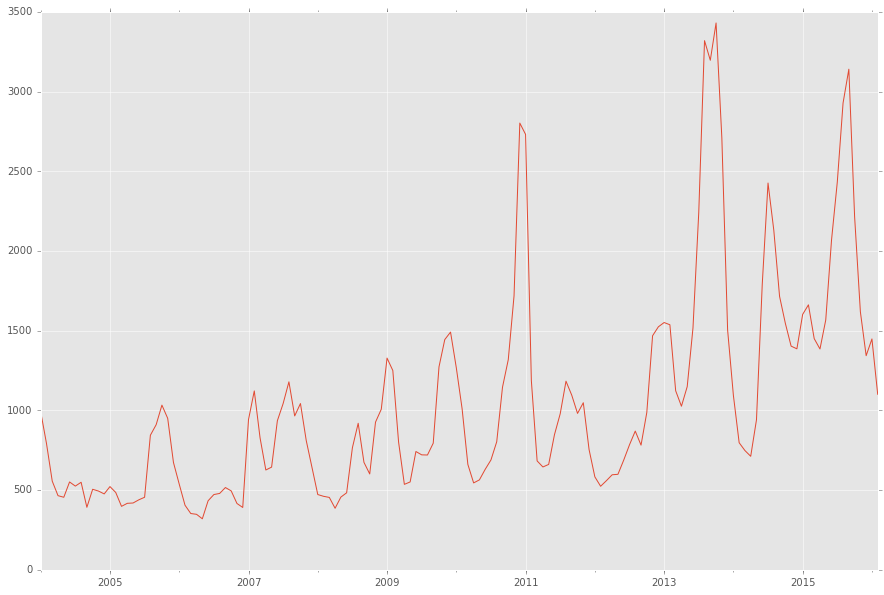

In [113]:
dfBang.priceMod.plot()

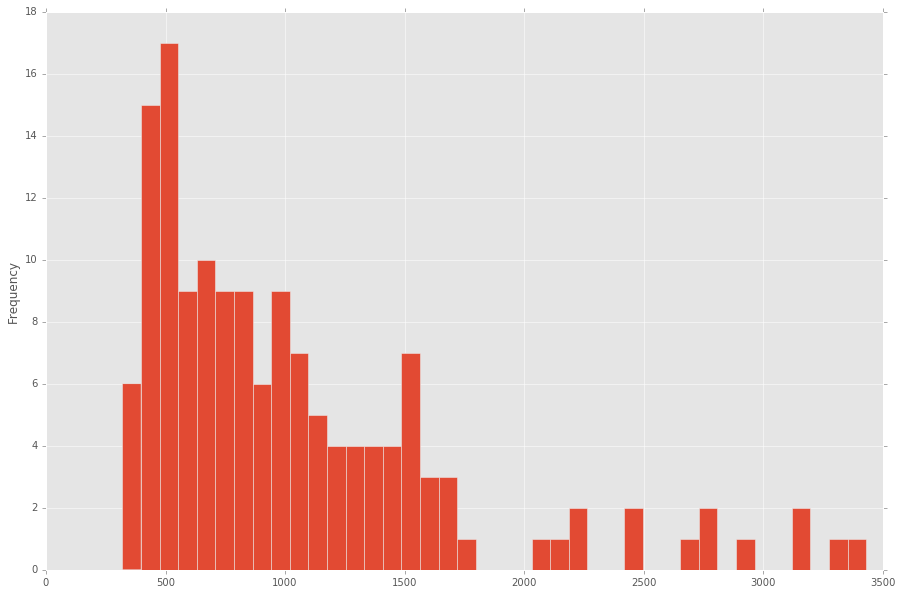

In [114]:
dfBang.priceMod.plot(kind = "hist", bins = 40)

In [115]:
dfBang['priceModLog'] = np.log(dfBang.priceMod)

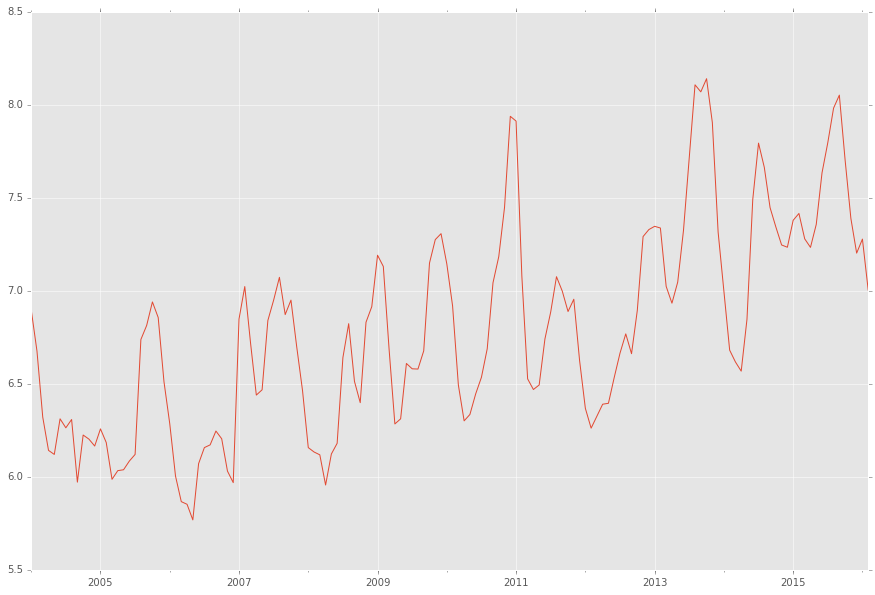

In [116]:
dfBang.priceModLog.plot()

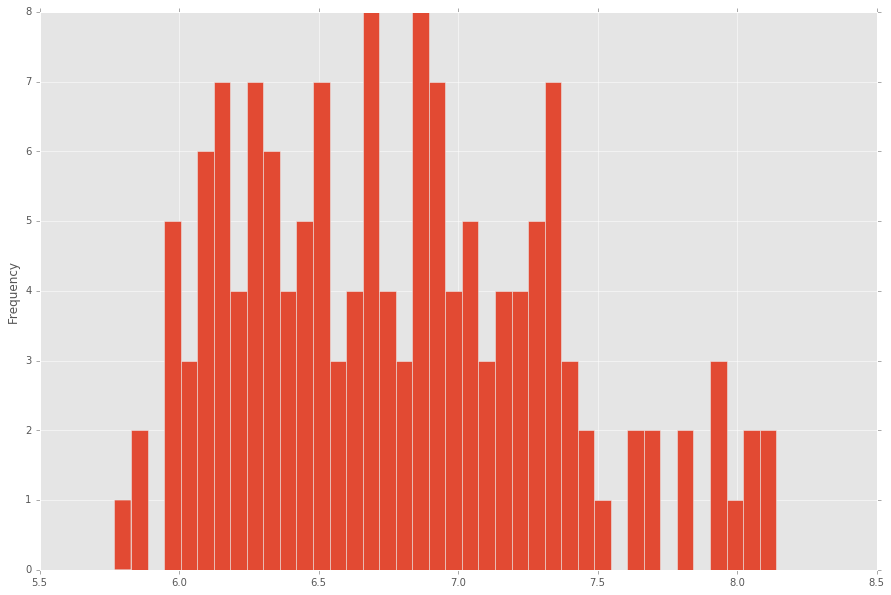

In [117]:
dfBang.priceModLog.plot(kind = "hist", bins = 40)

## Getting ready for prediction

In [118]:
dfBang.dtypes

quantity                int64
priceMod                int64
date           datetime64[ns]
priceModLog           float64
dtype: object

In [119]:
# What is the starting month of our data
dfBang.date.min()

Timestamp('2004-01-01 00:00:00')

In [120]:
# Convert date in datetimedelta figure starting from zero
dfBang["timeIndex"] = dfBang.date - dfBang.date.min()

In [121]:
dfBang.head()

,quantity,priceMod,date,priceModLog,timeIndex
2004-01,227832,991,2004-01-01,6.898715,0 days
2004-02,225133,793,2004-02-01,6.675823,31 days
2004-03,221952,556,2004-03-01,6.320768,60 days
2004-04,185150,465,2004-04-01,6.142037,91 days
2004-05,137390,455,2004-05-01,6.120297,121 days


In [122]:
dfBang.dtypes

quantity                 int64
priceMod                 int64
date            datetime64[ns]
priceModLog            float64
timeIndex      timedelta64[ns]
dtype: object

In [123]:
# Convert to months using the timedelta function
dfBang["timeIndex"] =  dfBang["timeIndex"]/np.timedelta64(1, 'M')

In [124]:
dfBang.timeIndex.head()

2004-01    0.000000
2004-02    1.018501
2004-03    1.971293
2004-04    2.989794
2004-05    3.975441
Freq: M, Name: timeIndex, dtype: float64

In [125]:
# Round the number to 0
dfBang["timeIndex"] = dfBang["timeIndex"].round(0).astype(int)

In [126]:
dfBang.timeIndex.head()

2004-01    0
2004-02    1
2004-03    2
2004-04    3
2004-05    4
Freq: M, Name: timeIndex, dtype: int64

In [127]:
dfBang.head()

,quantity,priceMod,date,priceModLog,timeIndex
2004-01,227832,991,2004-01-01,6.898715,0
2004-02,225133,793,2004-02-01,6.675823,1
2004-03,221952,556,2004-03-01,6.320768,2
2004-04,185150,465,2004-04-01,6.142037,3
2004-05,137390,455,2004-05-01,6.120297,4


## Mean  Model

This very simple forecasting model will be called the "mean model"

In [128]:
model_mean_pred = dfBang.priceModLog.mean()

In [129]:
# Let us store this as our Mean Predication Value
dfBang["priceMean"] = np.exp(model_mean_pred)

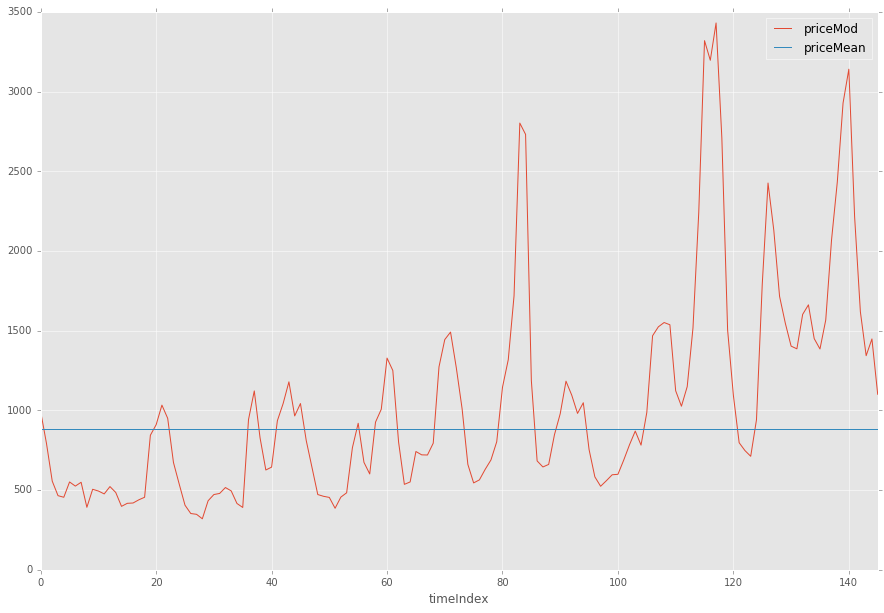

In [130]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean"])

**Can we measure the error rate?**

We will use Root Mean Squared Error (RMSE) to calculate our error values

$RMSE = \Sigma \sqrt{ (\hat{y} - y)^2/n} $ , where $\hat{y}$ is  predicted value of y

In [131]:
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

In [132]:
model_mean_RMSE = RMSE(dfBang.priceMean, dfBang.priceMod)
model_mean_RMSE

683.9533483996255

## Linear Trend Model

Let us start by plotting a linear trend model between priceModLog and time

In [133]:
dfBang.head()

,quantity,priceMod,date,priceModLog,timeIndex,priceMean
2004-01,227832,991,2004-01-01,6.898715,0,884.565812
2004-02,225133,793,2004-02-01,6.675823,1,884.565812
2004-03,221952,556,2004-03-01,6.320768,2,884.565812
2004-04,185150,465,2004-04-01,6.142037,3,884.565812
2004-05,137390,455,2004-05-01,6.120297,4,884.565812


In [134]:
model_linear = smf.ols('priceModLog ~ timeIndex', data = dfBang).fit()

In [135]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            priceModLog   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     139.8
Date:                Mon, 21 Mar 2016   Prob (F-statistic):           5.75e-23
Time:                        08:18:56   Log-Likelihood:                -72.317
No. Observations:                 146   AIC:                             148.6
Df Residuals:                     144   BIC:                             154.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      6.1121      0.066     92.830      0.000         5.982     6.242
timeIndex      0.0093      0.001     11.823      0.000         0.008     0.011
==============================================================================
Omnibus:                        4.750   Durbin-Watson:                   0.384
Prob(Omnibus):                  0.093   Jarque-Bera (JB):                4.739
Skew:                           0.405   Prob(JB):                       0.0935
Kurtosis:                       2.648   Cond. No.                         167.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
## Parameters for y = mx + c equation
model_linear.params

Intercept    6.112108
timeIndex    0.009283
dtype: float64

In [137]:
model_linear_pred = model_linear.predict()

In [138]:
model_linear_pred

array([ 6.11210813,  6.12139074,  6.13067334,  6.13995594,  6.14923855,
        6.15852115,  6.16780376,  6.17708636,  6.18636896,  6.19565157,
        6.20493417,  6.21421678,  6.22349938,  6.23278198,  6.24206459,
        6.25134719,  6.2606298 ,  6.2699124 ,  6.279195  ,  6.28847761,
        6.29776021,  6.30704282,  6.31632542,  6.32560802,  6.33489063,
        6.34417323,  6.35345583,  6.36273844,  6.37202104,  6.38130365,
        6.39058625,  6.39986885,  6.40915146,  6.41843406,  6.42771667,
        6.43699927,  6.44628187,  6.45556448,  6.46484708,  6.47412969,
        6.48341229,  6.49269489,  6.5019775 ,  6.5112601 ,  6.52054271,
        6.52982531,  6.53910791,  6.54839052,  6.55767312,  6.56695572,
        6.57623833,  6.58552093,  6.59480354,  6.60408614,  6.61336874,
        6.62265135,  6.63193395,  6.64121656,  6.65049916,  6.65978176,
        6.66906437,  6.67834697,  6.68762958,  6.69691218,  6.70619478,
        6.71547739,  6.72475999,  6.7340426 ,  6.7433252 ,  6.75

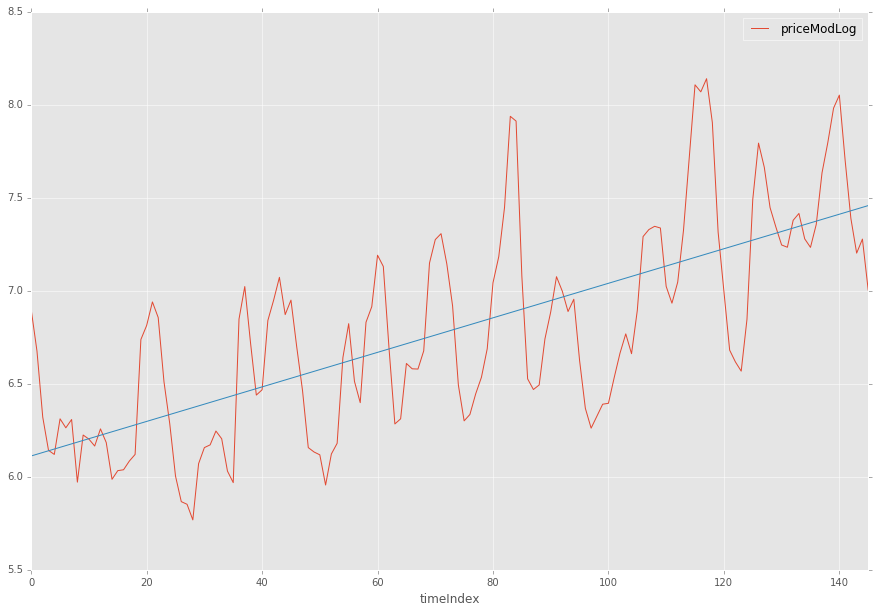

In [139]:
# Plot the prediction line
dfBang.plot(kind="line", x="timeIndex", y = "priceModLog")
plt.plot(dfBang.timeIndex,model_linear_pred, '-')

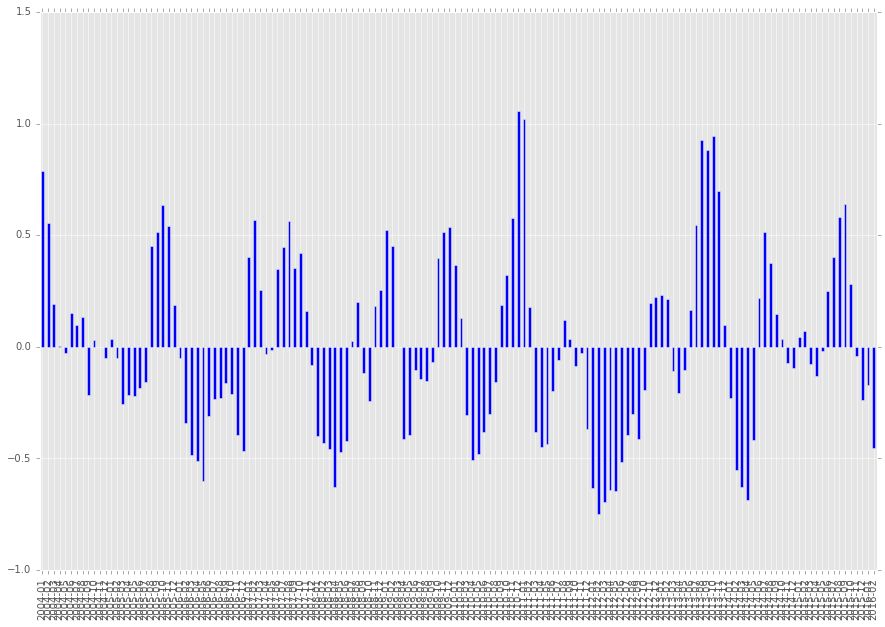

In [140]:
model_linear.resid.plot(kind = "bar")

**Is this a good model?**

What measures can we check to see if the model is good?

It is seen here (and  also evident on the regression line plot, if you look closely) that the linear trend model has a tendency to make an error of the same sign for many periods in a row. This tendency is measured in statistical terms by the **lag-1 autocorrelation and Durbin-Watson statistic**.  If there is no time pattern, the lag-1 autocorrelation should be very close to zero, and the Durbin-Watson statistic ought to be very close to 2, which is not the case here.  If the model has succeeded in extracting all the "signal" from the data, there should be no pattern at all in the errors: the error in the next period should not be correlated with any previous errors. The linear trend model obviously fails the autocorrelation test in this case.


In [141]:
## linear_pred = model_linear.predict(exog = dict(timeIndex=test.timeIndex))

In [142]:
dfBang["priceLinear"] = np.exp(model_linear_pred)

In [143]:
dfBang.head()

,quantity,priceMod,date,priceModLog,timeIndex,priceMean,priceLinear
2004-01,227832,991,2004-01-01,6.898715,0,884.565812,451.289090
2004-02,225133,793,2004-02-01,6.675823,1,884.565812,455.497732
2004-03,221952,556,2004-03-01,6.320768,2,884.565812,459.745622
2004-04,185150,465,2004-04-01,6.142037,3,884.565812,464.033127
2004-05,137390,455,2004-05-01,6.120297,4,884.565812,468.360617


In [144]:
# Root Mean Squared Error (RMSE)
model_linear_RMSE = RMSE(dfBang.priceLinear, dfBang.priceMod)
model_linear_RMSE

518.52360758414704

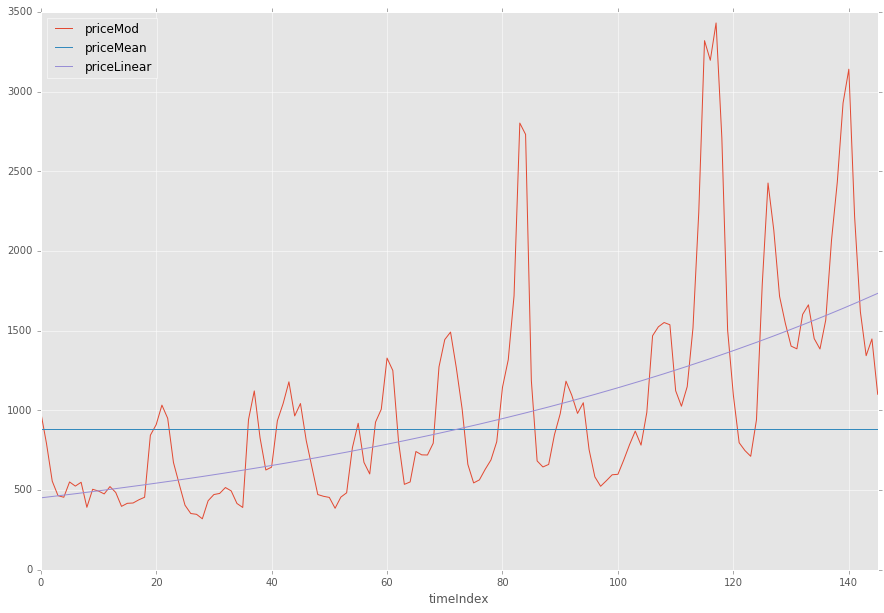

In [145]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear"])

## Random Walk Model

When faced with a time series that shows irregular growth, the best strategy may not be to try to directly predict the level of the series at each period (i.e., the quantity Yt). Instead, it may be better to try to predict the change that occurs from one period to the next (i.e., the quantity Yt - Yt-1). That is, it may be better to look at the first difference of the series, to see if a predictable pattern can be found there. For purposes of one-period-ahead forecasting, it is just as good to predict the next change as to predict the next level of the series, since the predicted change can be added to the current level to yield a predicted level. The simplest case of such a model is one that always predicts that the next change will be zero, as if the series is equally likely to go up or down in the next period regardless of what it has done in the past.


**Random Walk Model** $$ \hat{Y_t} = Y_{t-1} + \epsilon \\$$

**Random Walk Model with drift** $$ \hat{Y_t} = Y_{t-1} + c + \epsilon \\$$

In [146]:
dfBang["priceModLogShift1"] = dfBang.priceModLog.shift()

In [147]:
dfBang.head()

,quantity,priceMod,date,priceModLog,timeIndex,priceMean,priceLinear,priceModLogShift1
2004-01,227832,991,2004-01-01,6.898715,0,884.565812,451.289090,NaN
2004-02,225133,793,2004-02-01,6.675823,1,884.565812,455.497732,6.898715
2004-03,221952,556,2004-03-01,6.320768,2,884.565812,459.745622,6.675823
2004-04,185150,465,2004-04-01,6.142037,3,884.565812,464.033127,6.320768
2004-05,137390,455,2004-05-01,6.120297,4,884.565812,468.360617,6.142037


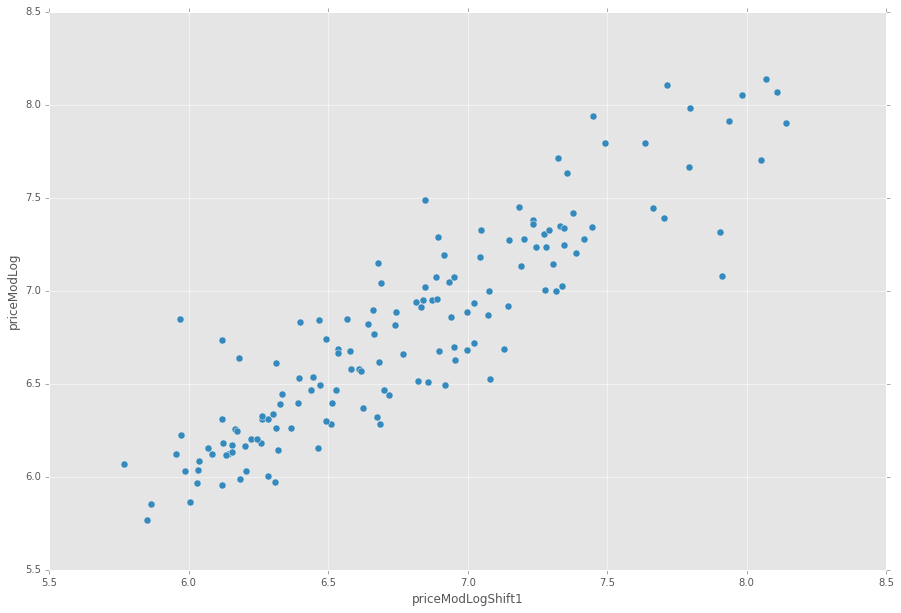

In [148]:
dfBang.plot(kind= "scatter", y = "priceModLog", x = "priceModLogShift1", s = 50)

In [149]:
# Lets plot the one-month difference curve
dfBang["priceModLogDiff"] = dfBang.priceModLog - dfBang.priceModLogShift1

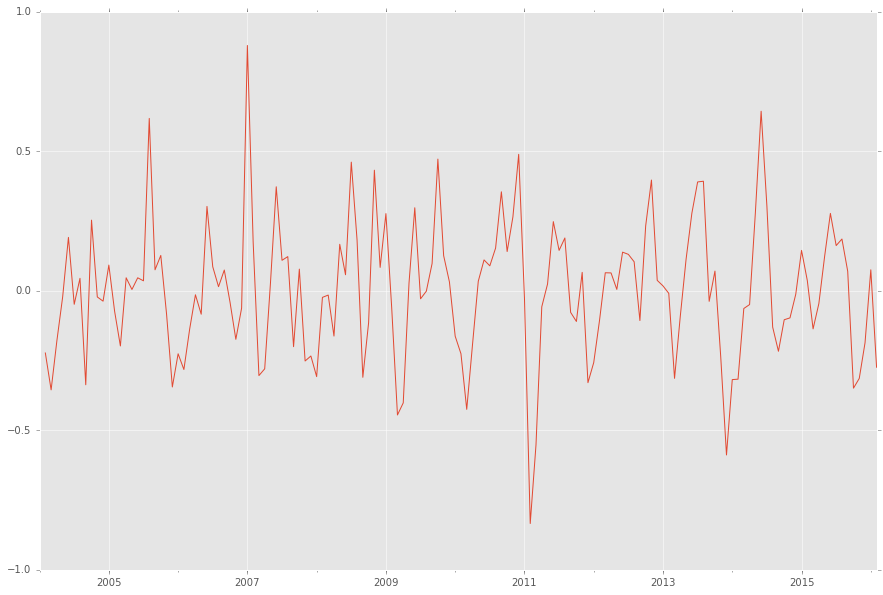

In [150]:
dfBang.priceModLogDiff.plot()

In [151]:
dfBang["priceRandom"] = np.exp(dfBang.priceModLogShift1)
dfBang.head()

,quantity,priceMod,date,priceModLog,timeIndex,priceMean,priceLinear,priceModLogShift1,priceModLogDiff,priceRandom
2004-01,227832,991,2004-01-01,6.898715,0,884.565812,451.289090,NaN,NaN,NaN
2004-02,225133,793,2004-02-01,6.675823,1,884.565812,455.497732,6.898715,-0.222891,991
2004-03,221952,556,2004-03-01,6.320768,2,884.565812,459.745622,6.675823,-0.355055,793
2004-04,185150,465,2004-04-01,6.142037,3,884.565812,464.033127,6.320768,-0.178731,556
2004-05,137390,455,2004-05-01,6.120297,4,884.565812,468.360617,6.142037,-0.021740,465


In [152]:
dfBang.tail()

,quantity,priceMod,date,priceModLog,timeIndex,priceMean,priceLinear,priceModLogShift1,priceModLogDiff,priceRandom
2015-10,1612160,2215,2015-10-01,7.703008,141,884.565812,1670.628673,8.051978,-0.348970,3140
2015-11,1071872,1618,2015-11-01,7.388946,142,884.565812,1686.208656,7.703008,-0.314062,2215
2015-12,513186,1343,2015-12-01,7.202661,143,884.565812,1701.933936,7.388946,-0.186285,1618
2016-01,507223,1448,2016-01-01,7.277939,144,884.565812,1717.805867,7.202661,0.075277,1343
2016-02,400359,1101,2016-02-01,7.003974,145,884.565812,1733.825817,7.277939,-0.273964,1448


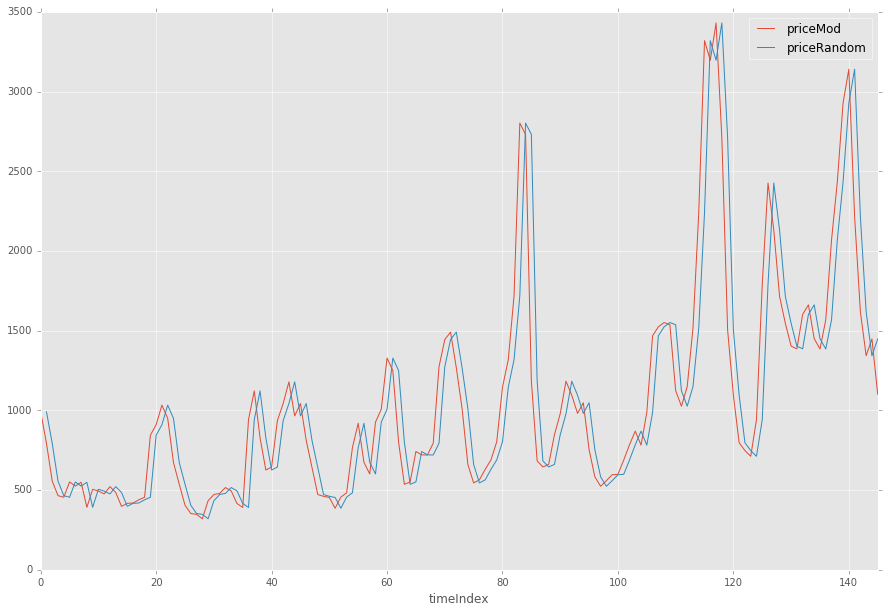

In [153]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod","priceRandom"])

In [154]:
# Root Mean Squared Error (RMSE)
model_random_RMSE = RMSE(dfBang.priceRandom, dfBang.priceMod)
model_random_RMSE

323.59240006420174

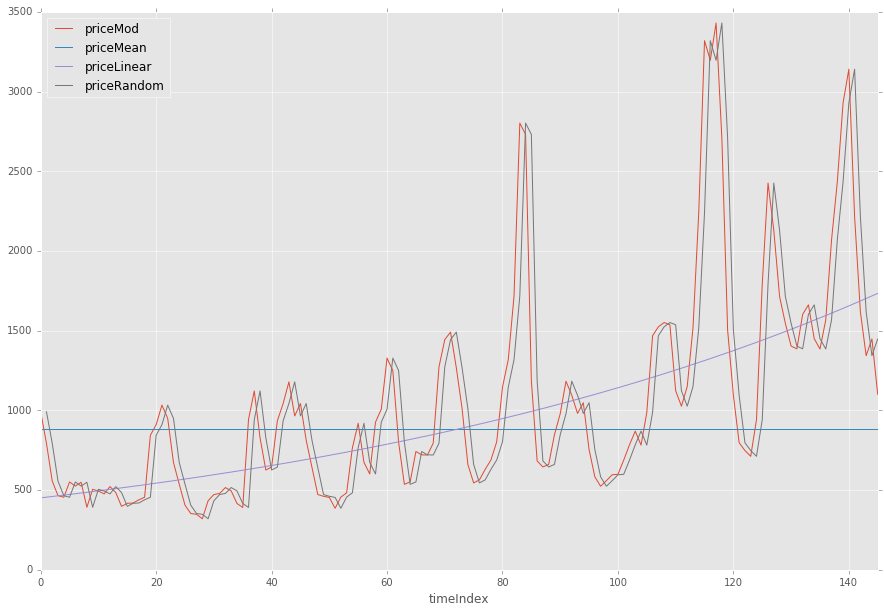

In [155]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear", "priceRandom"])

### Why do we do Transformation and Differencing?
- Transformations such as logarithms can help to stabilize the variance of a time series. 
- Differencing can help stabilize the mean of a time series by removing changes in the level of a time series, and so eliminating trend and seasonality.

## Simple Moving Average 

As a first step in moving beyond mean models, random walk model and linear trend models, nonseasonal patterns and trends can be extrapolated using a moving-average or smoothing model. The basic assumption behind averaging and smoothing models is that the time series is locally stationary with a slowly varying mean. Hence, we take a moving (local) average to estimate the current value of the mean and then use that as the forecast for the near future. This can be considered as a compromise between the mean model and the random-walk-without-drift-model. The same strategy can be used to estimate and extrapolate a local trend.  A moving average is often called a "smoothed" version of the original series because short-term averaging has the effect of smoothing out the bumps in the original series. By adjusting the degree of smoothing (the width of the moving average), we can hope to strike some kind of optimal balance between the performance of the mean and random walk models.

Simple Moving Average (SMA)

$$ \hat{y_t} = \frac{y_{t-1} + y_{t-2} + y_{t-3} + ... + y_{t-m}}{m} \\$$

In [156]:
# For smoothing the values we can use 12 month Moving Averages 
dfBang['priceModLogMA12'] = pd.rolling_mean(dfBang.priceModLog, window = 12)

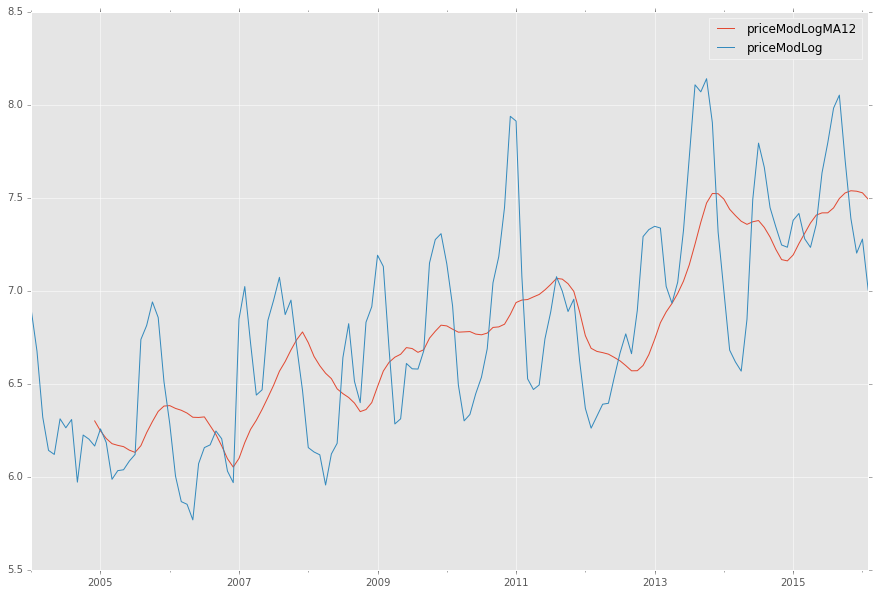

In [157]:
dfBang.plot(kind ="line", y=["priceModLogMA12", "priceModLog"])

The long-term forecasts from the SMA model are a horizontal straight line, just as in the random walk model. Thus, the SMA model assumes that there is no trend in the data. However, whereas the forecasts from the random walk model are simply equal to the last observed value, the forecasts from the SMA model are equal to a weighted average of recent values.

    

In [158]:
dfBang["priceMA12"] = np.exp(dfBang.priceModLogMA12)
dfBang.tail()

,quantity,priceMod,date,priceModLog,timeIndex,priceMean,priceLinear,priceModLogShift1,priceModLogDiff,priceRandom,priceModLogMA12,priceMA12
2015-10,1612160,2215,2015-10-01,7.703008,141,884.565812,1670.628673,8.051978,-0.348970,3140,7.526074,1855.805596
2015-11,1071872,1618,2015-11-01,7.388946,142,884.565812,1686.208656,7.703008,-0.314062,2215,7.537956,1877.986866
2015-12,513186,1343,2015-12-01,7.202661,143,884.565812,1701.933936,7.388946,-0.186285,1618,7.535329,1873.061120
2016-01,507223,1448,2016-01-01,7.277939,144,884.565812,1717.805867,7.202661,0.075277,1343,7.526907,1857.351582
2016-02,400359,1101,2016-02-01,7.003974,145,884.565812,1733.825817,7.277939,-0.273964,1448,7.492590,1794.694278


In [159]:
# Root Mean Squared Error (RMSE)
model_MA12_RMSE = RMSE(dfBang.priceMA12, dfBang.priceMod)
model_MA12_RMSE

518.82175104808096

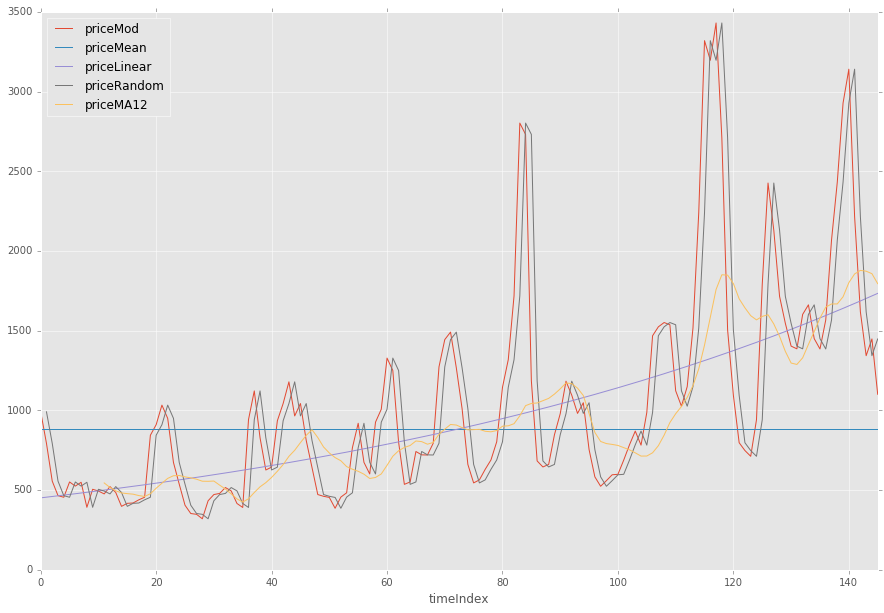

In [160]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear", "priceRandom", "priceMA12"])


## Simple Exponential Smoothing Model (SES)

Instead of equally weighting each of the observation, in the SES model we give more weightage to the recent observations and less to the older ones. This is done by the using a smoothing variable like alpha

$$ \hat{y_t} = \alpha y_{t-1} + (1-\alpha)\hat{y_{t-1}} \\$$

In [161]:
dfBang['priceModLogExp12'] = pd.ewma(dfBang.priceModLog, halflife=12)

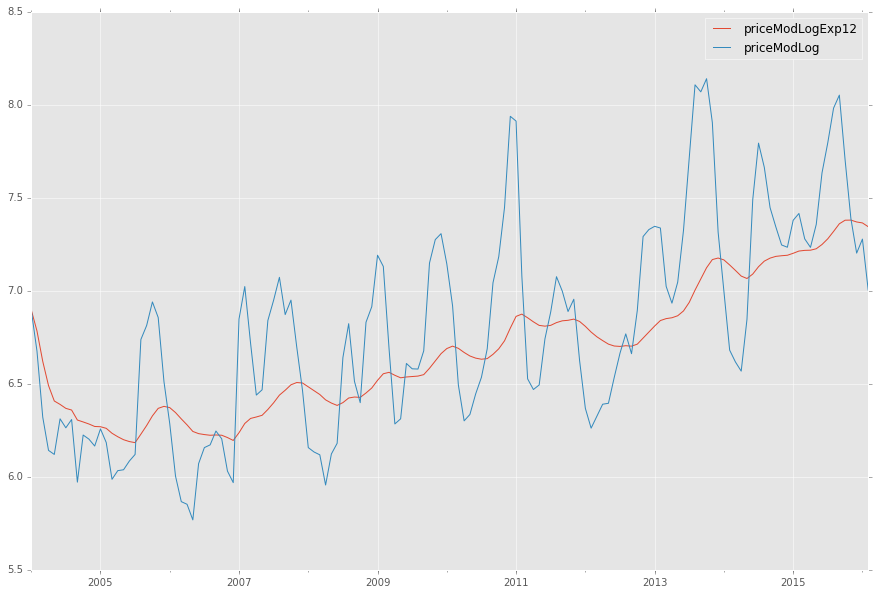

In [162]:
dfBang.plot(kind ="line", y=["priceModLogExp12", "priceModLog"])

In [171]:
dfBang["priceExp12"] = np.exp(dfBang.priceModLogExp12)
dfBang.tail()

,quantity,priceMod,date,priceModLog,timeIndex,priceMean,priceLinear,priceModLogShift1,priceModLogDiff,priceRandom,priceModLogMA12,priceMA12,priceModLogExp12,priceExp12
2015-10,1612160,2215,2015-10-01,7.703008,141,884.565812,1670.628673,8.051978,-0.348970,3140,7.526074,1855.805596,7.379526,1602.830556
2015-11,1071872,1618,2015-11-01,7.388946,142,884.565812,1686.208656,7.703008,-0.314062,2215,7.537956,1877.986866,7.380055,1603.678391
2015-12,513186,1343,2015-12-01,7.202661,143,884.565812,1701.933936,7.388946,-0.186285,1618,7.535329,1873.061120,7.370096,1587.786947
2016-01,507223,1448,2016-01-01,7.277939,144,884.565812,1717.805867,7.202661,0.075277,1343,7.526907,1857.351582,7.364923,1579.593558
2016-02,400359,1101,2016-02-01,7.003974,145,884.565812,1733.825817,7.277939,-0.273964,1448,7.492590,1794.694278,7.344660,1547.908508


In [164]:
# Root Mean Squared Error (RMSE)
model_Exp12_RMSE = RMSE(dfBang.priceExp12, dfBang.priceMod)
model_Exp12_RMSE

547.16281093335465

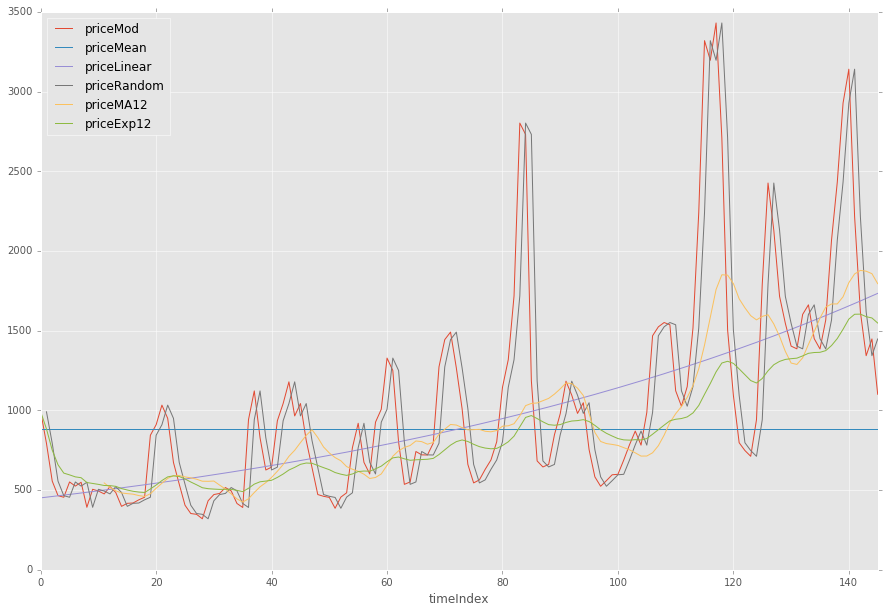

In [165]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear", "priceRandom",
                                             "priceMA12", "priceExp12"])

## Time Series Decomposition

- **Trend**: A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes we will refer to a trend “changing direction” when it might go from an increasing trend to a decreasing trend.
- **Seasonal**: A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week). Seasonality is always of a fixed and known period.
- **Cyclic**: A cyclic pattern exists when data exhibit rises and falls that are not of fixed period. The duration of these fluctuations is usually of at least 2 years.

$$ y_t=S_t+T_t+E_t \\$$

where $y_t$ is the data at period `t`, $S_t$ is the seasonal component at period 't', $T_t$ is the trend-cycle component at period tt and $E_t$ is the remainder (or irregular or error) component at period tt. 

Alternatively, a multiplicative model would be written as

$$ y_t=S_t*T_t*E_t \\$$

The additive model is most appropriate if the magnitude of the seasonal fluctuations or the variation around the trend-cycle does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative model is more appropriate. With economic time series, multiplicative models are common.

An alternative to using a multiplicative model, is to first transform the data until the variation in the series appears to be stable over time, and then use an additive model. When a log transformation has been used, this is equivalent to using a multiplicative decomposition because

$$ log y_t=log S_t+ log T_t + log E_t \\$$

Sometimes, the trend-cycle component is simply called the “trend” component, even though it may contain cyclic behaviour as well.

In [166]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [167]:
dfBang.dtypes

quantity                      int64
priceMod                      int64
date                 datetime64[ns]
priceModLog                 float64
timeIndex                     int64
priceMean                   float64
priceLinear                 float64
priceModLogShift1           float64
priceModLogDiff             float64
priceRandom                 float64
priceModLogMA12             float64
priceMA12                   float64
priceModLogExp12            float64
priceExp12                  float64
dtype: object

In [170]:
dfBang.tail()

,quantity,priceMod,date,priceModLog,timeIndex,priceMean,priceLinear,priceModLogShift1,priceModLogDiff,priceRandom,priceModLogMA12,priceMA12,priceModLogExp12,priceExp12
2015-10,1612160,2215,2015-10-01,7.703008,141,884.565812,1670.628673,8.051978,-0.348970,3140,7.526074,1855.805596,7.379526,1602.830556
2015-11,1071872,1618,2015-11-01,7.388946,142,884.565812,1686.208656,7.703008,-0.314062,2215,7.537956,1877.986866,7.380055,1603.678391
2015-12,513186,1343,2015-12-01,7.202661,143,884.565812,1701.933936,7.388946,-0.186285,1618,7.535329,1873.061120,7.370096,1587.786947
2016-01,507223,1448,2016-01-01,7.277939,144,884.565812,1717.805867,7.202661,0.075277,1343,7.526907,1857.351582,7.364923,1579.593558
2016-02,400359,1101,2016-02-01,7.003974,145,884.565812,1733.825817,7.277939,-0.273964,1448,7.492590,1794.694278,7.344660,1547.908508


In [172]:
dfBang.index = dfBang.index.to_datetime()

In [173]:
dfBang.head()

,quantity,priceMod,date,priceModLog,timeIndex,priceMean,priceLinear,priceModLogShift1,priceModLogDiff,priceRandom,priceModLogMA12,priceMA12,priceModLogExp12,priceExp12
2004-01-01,227832,991,2004-01-01,6.898715,0,884.565812,451.289090,NaN,NaN,NaN,NaN,NaN,6.898715,991.000000
2004-02-01,225133,793,2004-02-01,6.675823,1,884.565812,455.497732,6.898715,-0.222891,991,NaN,NaN,6.784051,883.641198
2004-03-01,221952,556,2004-03-01,6.320768,2,884.565812,459.745622,6.675823,-0.355055,793,NaN,NaN,6.620623,750.412129
2004-04-01,185150,465,2004-04-01,6.142037,3,884.565812,464.033127,6.320768,-0.178731,556,NaN,NaN,6.490419,658.799360
2004-05-01,137390,455,2004-05-01,6.120297,4,884.565812,468.360617,6.142037,-0.021740,465,NaN,NaN,6.407606,606.440185


In [174]:
decomposition = seasonal_decompose(dfBang.priceModLog, model = "additive")

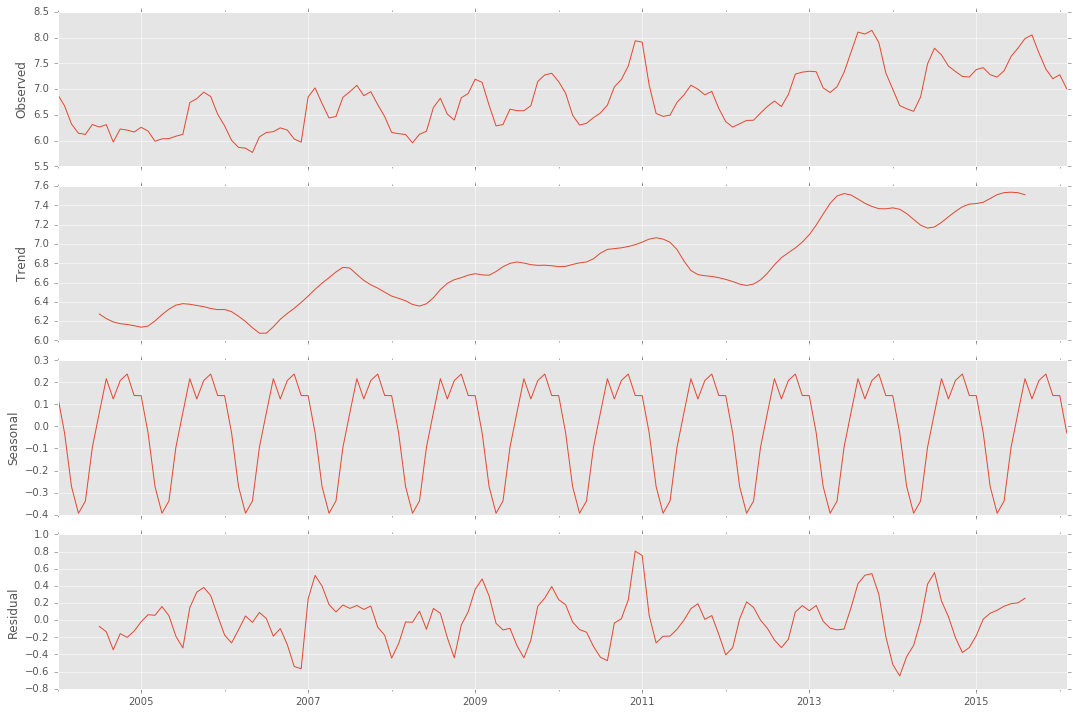

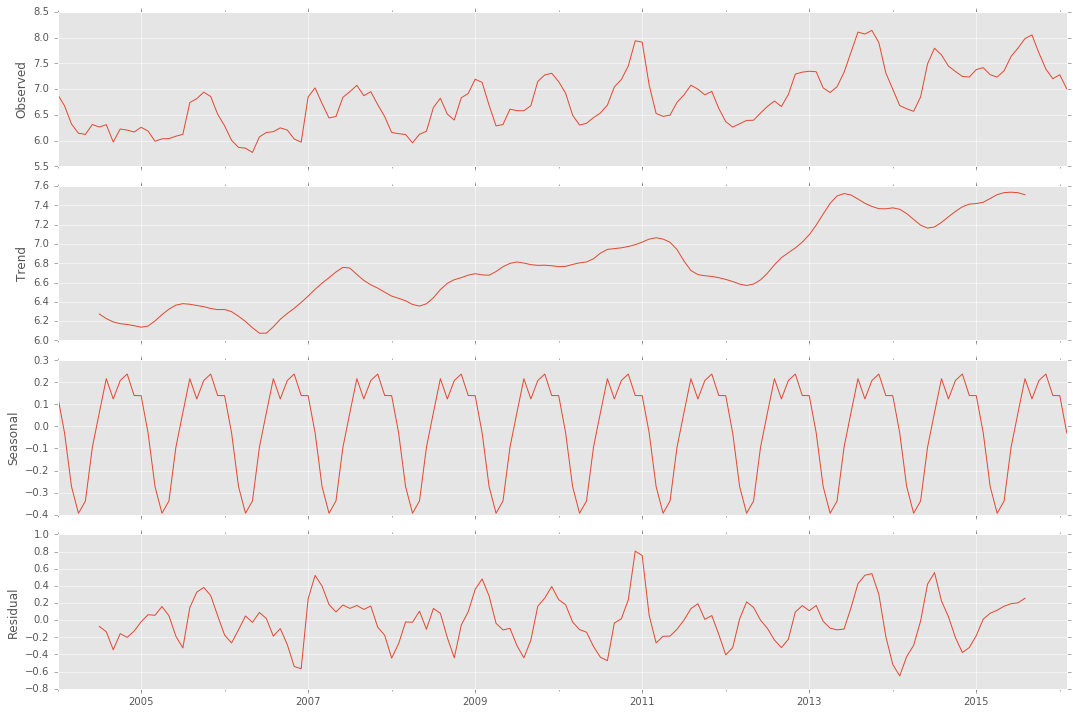

In [175]:
decomposition.plot()

In [176]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

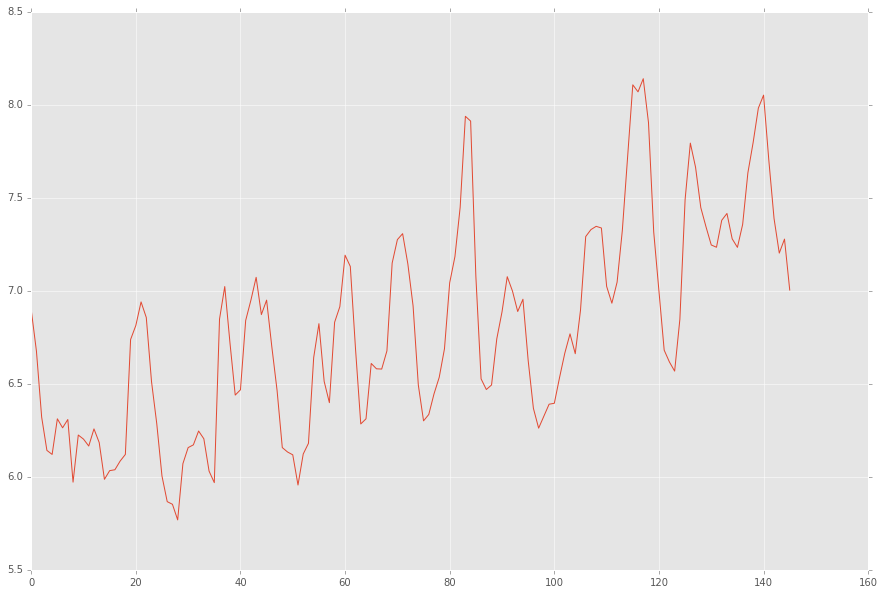

In [177]:
plt.plot(dfBang.timeIndex, dfBang.priceModLog, '-')

In [178]:
dfBang["priceDecomp"] = np.exp(trend + seasonal)

In [179]:
# Root Mean Squared Error (RMSE)
model_Decomp_RMSE = RMSE(dfBang.priceDecomp, dfBang.priceMod)
model_Decomp_RMSE

374.10858464802351

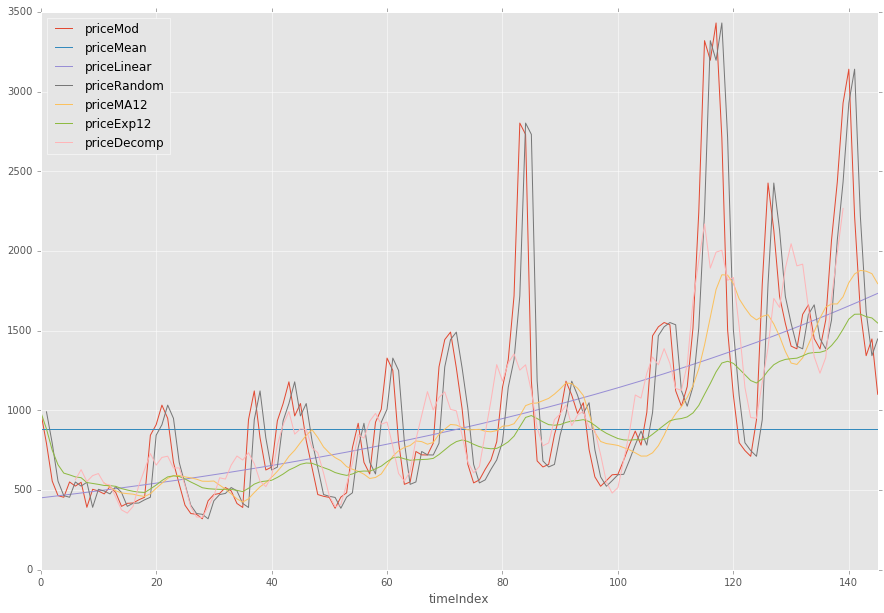

In [180]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear", "priceRandom",
                                             "priceMA12", "priceExp12", "priceDecomp"])

## Auto Regressive Models - AR(p)

In an autoregression model, we forecast the variable of interest using a linear combination of past values of the variable. The term autoregression indicates that it is a regression of the variable against itself.

Thus an autoregressive model of order (p) can be written as

$$ y_t = c + m_1y_{t-1} + m_2y_{t-2} + m_3y_{t-3} + .. \\$$

**Random walk model is an AR(1) model with ** $$m_1=1,  c = 0\\$$
**Random walk model with drift model ** $$m_1=1,  c \not= 0\\$$

We normally restrict autoregressive models to stationary data, and then some constraints on the values of the parameters are required.

For an AR(1) model:   $$ −1<m_1<−1 \\$$
For an AR(2) model:   
$$ −1<m_2<−1, m_1 + m_2 < 1, m_2 - m_1 <1 \\$$

## Moving Average Model - MA(q)

Rather than use past values of the forecast variable in a regression, a moving average model uses past forecast errors in a regression-like model.

$$ y_t=c+e_t+l_1 e_{t−1}+l_2 e_{t−2} + ... + l_q e_{t-q} \\$$

where `e` is white noise. We refer to this as an MA(`q`) model. Of course, we do not observe the values of etet, so it is not really regression in the usual sense.

Notice that each value of `y(t)` can be thought of as a weighted moving average of the past few forecast errors. However, moving average models should not be confused with moving average smoothing. A moving average model is used for forecasting future values while moving average smoothing is used for estimating the trend-cycle of past values.

## ARIMA Model

If we combine differencing with autoregression and a moving average model, we obtain a non-seasonal ARIMA model. ARIMA is an acronym for AutoRegressive Integrated Moving Average model (“integration” in this context is the reverse of differencing). The full model can be written as

- **Number of AR (Auto-Regressive) terms (p)**: AR terms are just lags of dependent variable. For instance if p is 5, the predictors for y(t) will be y(t-1)….y(t-5).
- **Number of MA (Moving Average) terms (q)**: MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for y(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
- **Number of Differences (d)**: These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

- **Autocorrelation Function (ACF)**: It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
- **Partial Autocorrelation Function (PACF)**: This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.


In MA model, noise / shock quickly vanishes with time. The AR model has a much lasting effect of the shock.

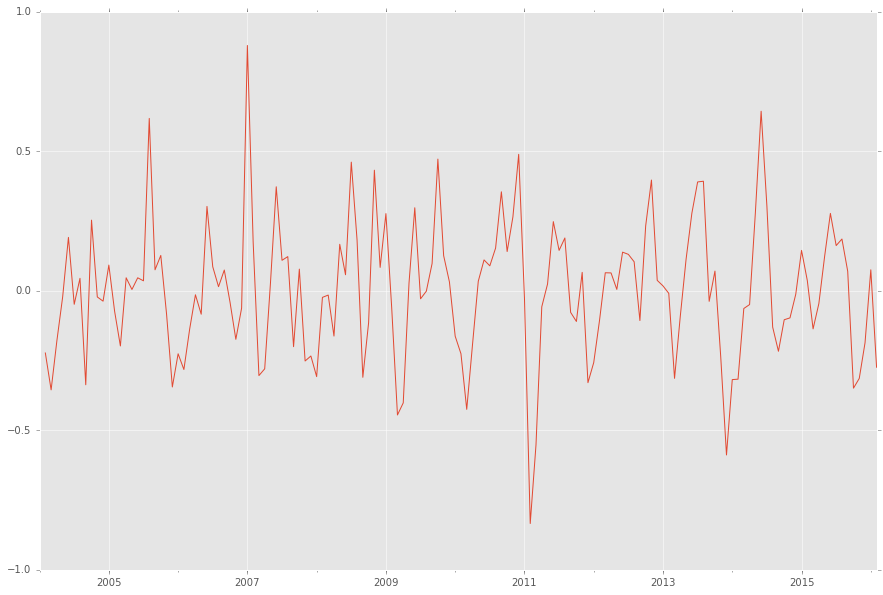

In [181]:
dfBang.priceModLogDiff.plot()

** Augmented Dickey Fuller Test unit root test **

Augmented Dickey-Fuller unit root test

The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.

$$ Y_t = \rho * Y_{t-1} + \epsilon_t \\$$
$$  Y_t - Y_{t-1} = (\rho - 1) Y_{t - 1} + \epsilon_t \\$$

We have to test if p – 1 is significantly different than zero or not. If the null hypothesis gets rejected, we’ll get a stationary time series.

In [182]:
# For Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller

In [183]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [243]:
ts = dfBang.priceModLog

In [230]:
ts_diff = dfBang.priceModLogDiff

In [231]:
ts_diff.dropna(inplace=True)

In [232]:
dftest = adfuller(ts_diff, autolag='AIC')

In [233]:
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])

In [234]:
dfoutput

Test Statistic                -7.293246e+00
p-value                        1.399305e-10
# of Lags Used                 7.000000e+00
Number of Observations Used    1.370000e+02
dtype: float64

In [235]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [236]:
lag_acf = acf(ts_diff, nlags=20)

In [237]:
lag_acf

array([ 1.        ,  0.40215445, -0.02855346, -0.21472715, -0.23756032,
       -0.26332645, -0.22038359, -0.08576989, -0.0754398 ,  0.01497797,
        0.12361818,  0.20862956,  0.158123  ,  0.02053933, -0.01290934,
       -0.07097602, -0.17993659, -0.09514604, -0.04878255, -0.08854117,
       -0.18810881])

In [238]:
ACF = pd.Series(lag_acf)

In [239]:
ACF

0     1.000000
1     0.402154
2    -0.028553
3    -0.214727
4    -0.237560
5    -0.263326
6    -0.220384
7    -0.085770
8    -0.075440
9     0.014978
10    0.123618
11    0.208630
12    0.158123
13    0.020539
14   -0.012909
15   -0.070976
16   -0.179937
17   -0.095146
18   -0.048783
19   -0.088541
20   -0.188109
dtype: float64

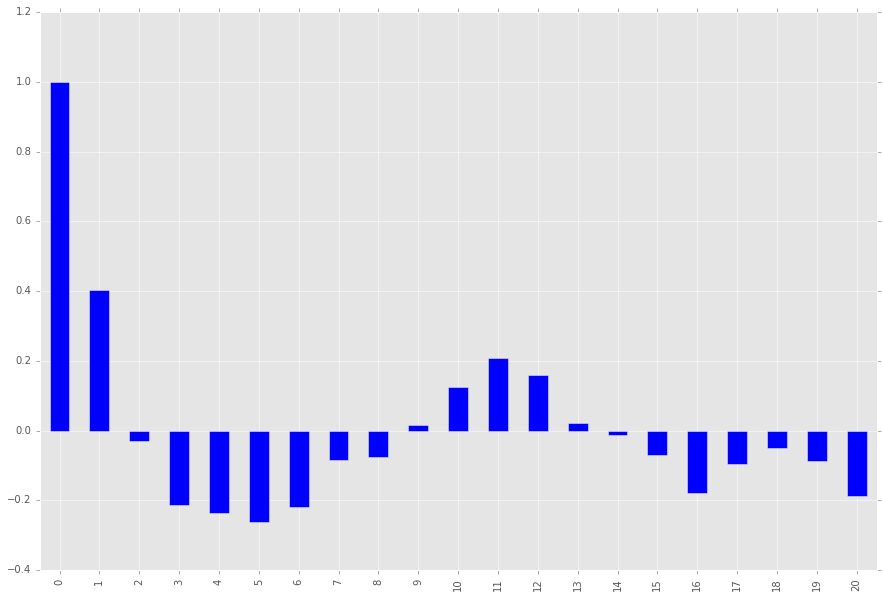

In [240]:
ACF.plot(kind = "bar")

In [241]:
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

In [197]:
PACF = pd.Series(lag_pacf)

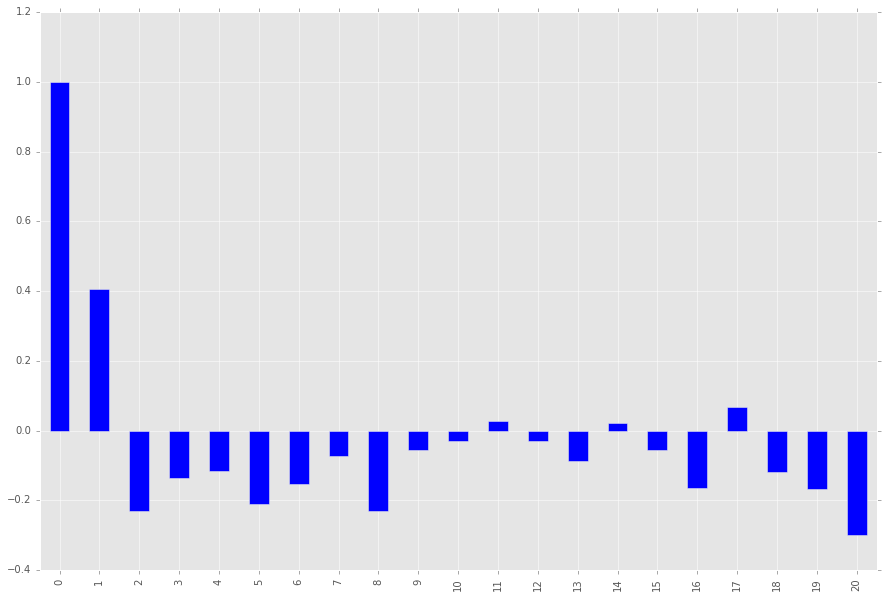

In [198]:
PACF.plot(kind = "bar")

In [199]:
from statsmodels.tsa.arima_model import ARIMA

### Running the ARIMA Model 

In [265]:
model = ARIMA(ts, order=(4, 1, 2))

In [266]:
results_ARIMA = model.fit(disp=-1)

In [267]:
results_ARIMA

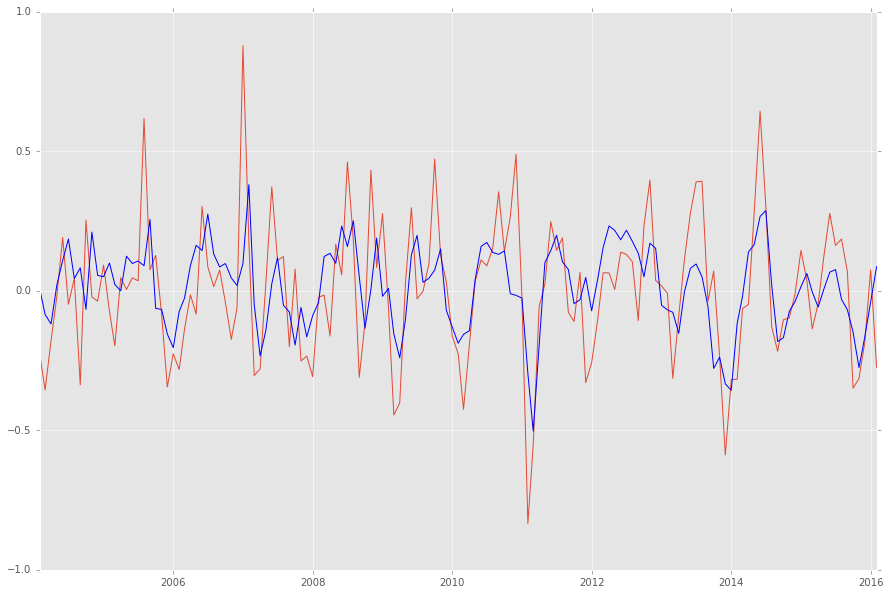

In [268]:
plt.plot(ts_diff)
plt.plot(results_ARIMA.fittedvalues, color='blue')

In [254]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.tail()

2015-10-01   -0.151752
2015-11-01   -0.272074
2015-12-01   -0.167180
2016-01-01   -0.033644
2016-02-01    0.084437
Freq: MS, dtype: float64

In [258]:
predictions_ARIMA_diff.sum()

2.201831291135293

In [257]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.tail()

2015-10-01    2.590293
2015-11-01    2.318218
2015-12-01    2.151038
2016-01-01    2.117394
2016-02-01    2.201831
Freq: MS, dtype: float64

In [256]:
ts.ix[0]

6.8987145343299883

In [252]:
predictions_ARIMA_log = pd.Series(ts.ix[0], index=ts.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.tail()

2015-10-01    9.489007
2015-11-01    9.216933
2015-12-01    9.049753
2016-01-01    9.016109
2016-02-01    9.100546
Freq: MS, dtype: float64

In [248]:
dfBang['priceARIMA'] = np.exp(predictions_ARIMA_log)

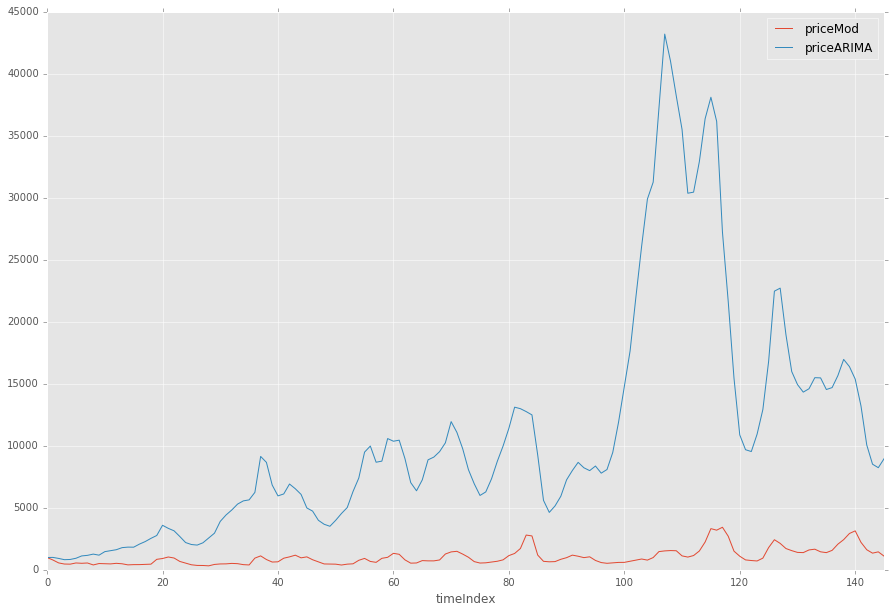

In [250]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceARIMA"])

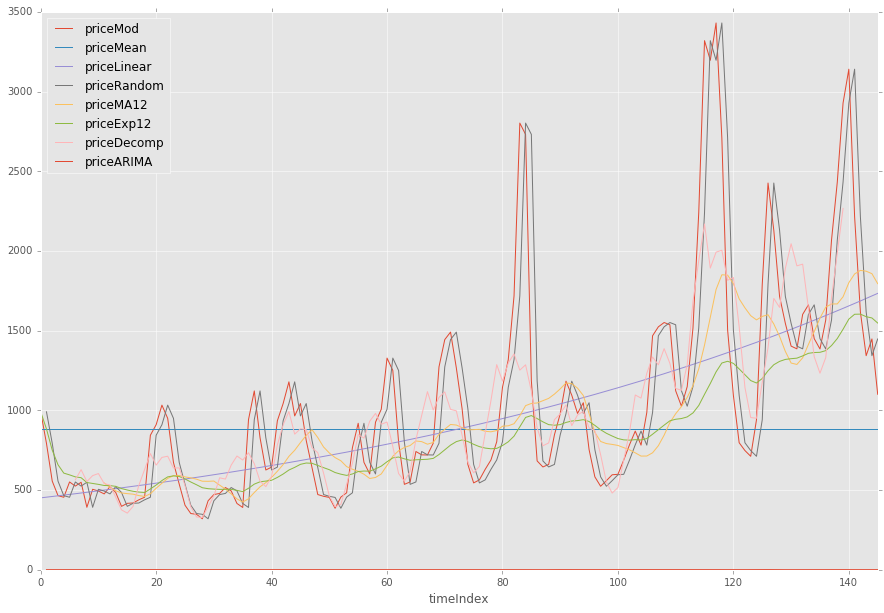

In [212]:
dfBang.plot(kind="line", x="timeIndex", y = ["priceMod", "priceMean", "priceLinear", "priceRandom",
                                             "priceMA12", "priceExp12", "priceDecomp", "priceARIMA"])